# 🏦 Classification : Approbation de Prêts Bancaires

**Objectif** : Prédire si un prêt sera approuvé (1) ou rejeté (0) en fonction des caractéristiques du demandeur.

Ce notebook suit les étapes classiques d'un projet de classification :
1. Chargement et exploration des données
2. Préparation des données
3. Modélisation (3 algorithmes)
4. Évaluation et comparaison
5. Pistes de déploiement

---

## 1. Imports et Configuration

In [ ]:
%pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# Config affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Librairies chargées avec succès !")

✅ Librairies chargées avec succès !


## 2. Chargement et Exploration des Données

In [4]:
# Charger les données
df = pd.read_csv('loan_data.csv')

print(f"📊 Dimensions : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
df.head()

📊 Dimensions : 45,000 lignes × 14 colonnes


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
# Aperçu des types et valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
# Statistiques descriptives
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


### 2.1 Distribution de la variable cible

📈 Distribution de la variable cible (loan_status) :
   - Approuvé (1) : 22.2%
   - Rejeté (0)   : 77.8%


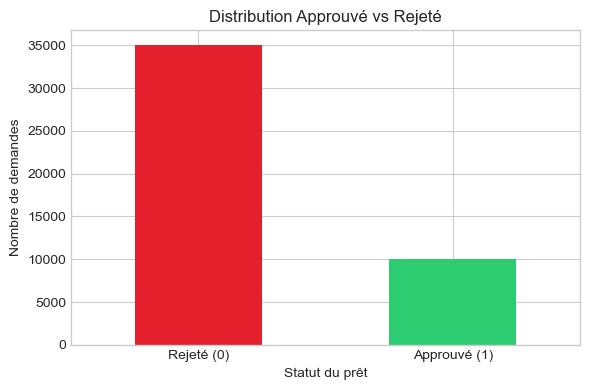

In [7]:
# Distribution de loan_status (notre variable cible)
target_dist = df['loan_status'].value_counts(normalize=True) * 100

print("📈 Distribution de la variable cible (loan_status) :")
print(f"   - Approuvé (1) : {target_dist[1]:.1f}%")
print(f"   - Rejeté (0)   : {target_dist[0]:.1f}%")

# Visualisation
fig, ax = plt.subplots(figsize=(6, 4))
df['loan_status'].value_counts().plot(kind='bar', color=['#E3202B', '#2ecc71'], ax=ax)
ax.set_xlabel('Statut du prêt')
ax.set_ylabel('Nombre de demandes')
ax.set_title('Distribution Approuvé vs Rejeté')
ax.set_xticklabels(['Rejeté (0)', 'Approuvé (1)'], rotation=0)
plt.tight_layout()
plt.show()

### 💡 Commentaire métier

Le dataset est **relativement pas trés équilibré** (environ 78% approuvés / 22% rejetés). 

Dans un contexte bancaire réel :
- **Faux Négatif (FN)** = Rejeter un bon client → Perte d'opportunité commerciale
- **Faux Positif (FP)** = Approuver un mauvais payeur → Risque de défaut = **Perte financière directe**

➡️ En général, les banques privilégient la **Precision** pour minimiser les FP (défauts de paiement).

---

## 3. Préparation des Données

In [8]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [9]:
# Identifier les colonnes catégorielles
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes catégorielles : {cat_cols}")

# Voir les modalités
for col in cat_cols:
    print(f"\n{col} : {df[col].unique()}")

Colonnes catégorielles : ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

person_gender : ['female' 'male']

person_education : ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

previous_loan_defaults_on_file : ['No' 'Yes']


### 3.1 Encodage des variables catégorielles

On utilise **Label Encoding** pour simplicité. En production, on pourrait utiliser One-Hot Encoding ou Target Encoding selon le contexte.

In [10]:
# Copie du dataframe pour ne pas modifier l'original
df_encoded = df.copy()

# Label Encoding pour chaque colonne catégorielle
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\n✅ Encodage terminé !")

person_gender: {'female': 0, 'male': 1}
person_education: {'Associate': 0, 'Bachelor': 1, 'Doctorate': 2, 'High School': 3, 'Master': 4}
person_home_ownership: {'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}
loan_intent: {'DEBTCONSOLIDATION': 0, 'EDUCATION': 1, 'HOMEIMPROVEMENT': 2, 'MEDICAL': 3, 'PERSONAL': 4, 'VENTURE': 5}
previous_loan_defaults_on_file: {'No': 0, 'Yes': 1}

✅ Encodage terminé !


### 3.2 Séparation Features / Target et Train / Test

In [11]:
# Séparer X (features) et y (target)
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

print(f"Features (X) : {X.shape}")
print(f"Target (y)   : {y.shape}")

Features (X) : (45000, 13)
Target (y)   : (45000,)


In [12]:
# Split Train / Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Garder les mêmes proportions de classes
)

print(f"Train : {X_train.shape[0]:,} observations")
print(f"Test  : {X_test.shape[0]:,} observations")

Train : 36,000 observations
Test  : 9,000 observations


### 3.3 Normalisation (pour la Régression Logistique)

La régression logistique est sensible à l'échelle des variables. On normalise les données pour ce modèle.

In [13]:
# Scaler pour la régression logistique
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Données normalisées pour la régression logistique")

✅ Données normalisées pour la régression logistique


---

## 4. Modélisation

On compare 3 algorithmes classiques :
1. **Régression Logistique** - Modèle linéaire, interprétable, baseline
2. **Random Forest** - Ensemble d'arbres (bagging), robuste
3. **XGBoost** - Gradient Boosting, souvent le meilleur sur données tabulaires

In [14]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    """Entraîne et évalue un modèle"""
    # Entraînement
    model.fit(X_tr, y_tr)
    
    # Prédictions
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    
    # Métriques
    metrics = {
        'Accuracy': accuracy_score(y_te, y_pred),
        'Precision': precision_score(y_te, y_pred),
        'Recall': recall_score(y_te, y_pred),
        'F1-Score': f1_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_proba)
    }
    
    results[name] = metrics
    return model, y_pred, y_proba

### 4.1 Régression Logistique

In [15]:
# Régression Logistique (utilise les données normalisées)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model, y_pred_lr, y_proba_lr = evaluate_model(
    'Logistic Regression', lr_model, 
    X_train_scaled, X_test_scaled, y_train, y_test
)

print("✅ Régression Logistique entraînée")
print(classification_report(y_test, y_pred_lr, target_names=['Rejeté', 'Approuvé']))

✅ Régression Logistique entraînée
              precision    recall  f1-score   support

      Rejeté       0.93      0.94      0.93      7000
    Approuvé       0.78      0.75      0.76      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.84      0.85      9000
weighted avg       0.90      0.90      0.90      9000



### 4.2 Random Forest

In [16]:
# Random Forest (n'a pas besoin de normalisation)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model, y_pred_rf, y_proba_rf = evaluate_model(
    'Random Forest', rf_model, 
    X_train, X_test, y_train, y_test
)

print("✅ Random Forest entraîné")
print(classification_report(y_test, y_pred_rf, target_names=['Rejeté', 'Approuvé']))

✅ Random Forest entraîné
              precision    recall  f1-score   support

      Rejeté       0.94      0.97      0.95      7000
    Approuvé       0.89      0.77      0.83      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000



### 4.3 XGBoost

In [17]:
# XGBoost (n'a pas besoin de normalisation)
xgb_model = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_model, y_pred_xgb, y_proba_xgb = evaluate_model(
    'XGBoost', xgb_model, 
    X_train, X_test, y_train, y_test
)

print("✅ XGBoost entraîné")
print(classification_report(y_test, y_pred_xgb, target_names=['Rejeté', 'Approuvé']))

✅ XGBoost entraîné
              precision    recall  f1-score   support

      Rejeté       0.95      0.97      0.96      7000
    Approuvé       0.89      0.82      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.92      0.90      0.91      9000
weighted avg       0.94      0.94      0.94      9000



---

## 5. Comparaison des Modèles

In [27]:
# Tableau comparatif
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Afficher avec style
print("📊 Comparaison des performances :\n")
results_df.style.highlight_max(axis=0, color='darkgreen')

📊 Comparaison des performances :



,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.896800,0.777900,0.749500,0.763400,0.951400
Random Forest,0.927700,0.887900,0.772000,0.825900,0.973800
XGBoost,0.937000,0.888300,0.819500,0.852500,0.979300


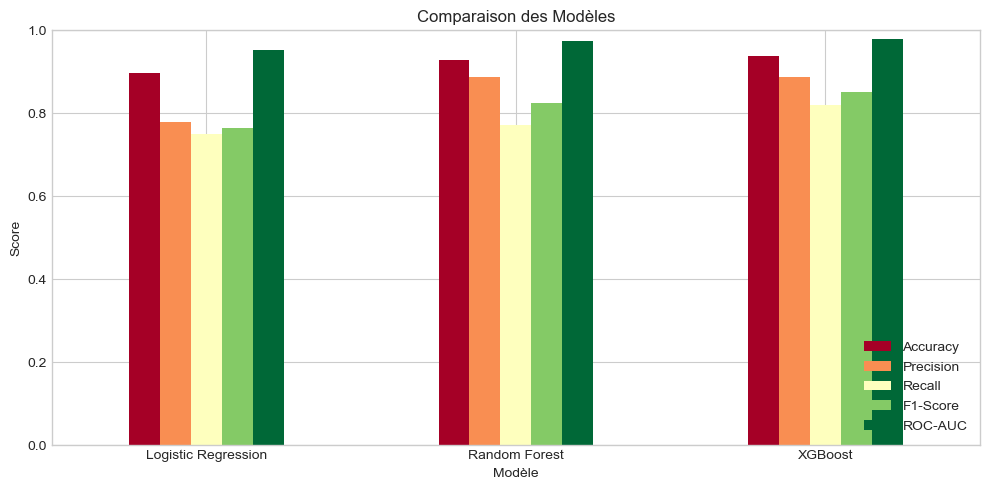

In [22]:
# Visualisation des métriques
fig, ax = plt.subplots(figsize=(10, 5))
results_df.plot(kind='bar', ax=ax, colormap='RdYlGn')
ax.set_title('Comparaison des Modèles')
ax.set_xlabel('Modèle')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
ax.set_xticklabels(results_df.index, rotation=0)
plt.tight_layout()
plt.show()

### 5.1 Matrices de Confusion

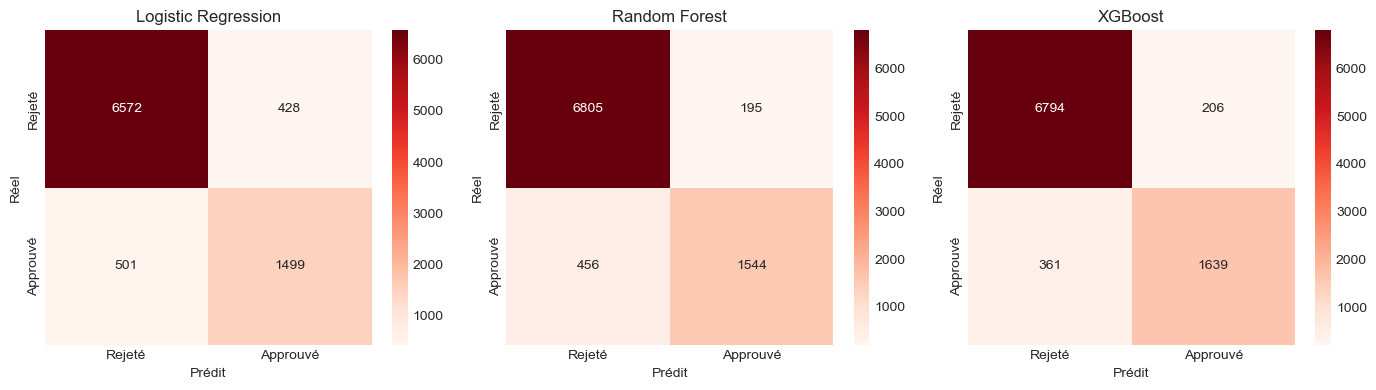

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, y_pred) in zip(axes, [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax,
                xticklabels=['Rejeté', 'Approuvé'],
                yticklabels=['Rejeté', 'Approuvé'])
    ax.set_title(name)
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')

plt.tight_layout()
plt.show()

### 5.2 Courbes ROC

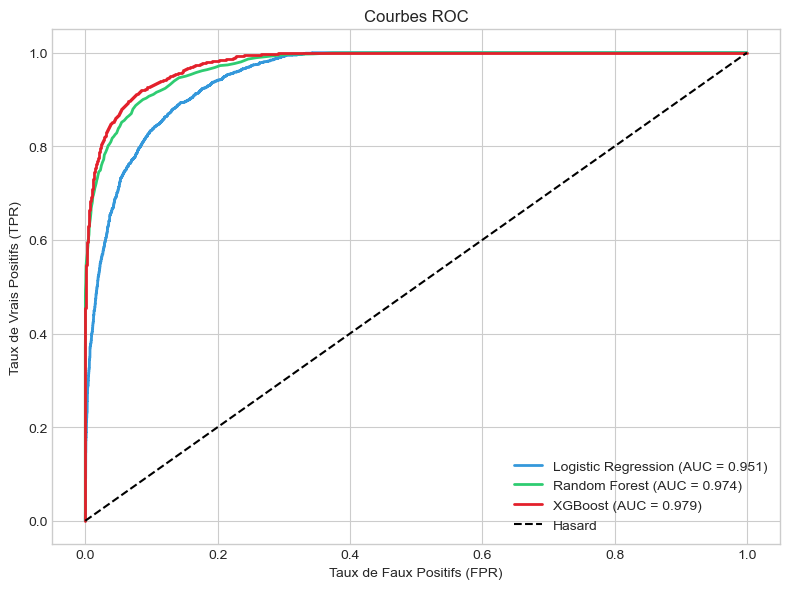

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, y_proba, color in [
    ('Logistic Regression', y_proba_lr, '#3498db'),
    ('Random Forest', y_proba_rf, '#2ecc71'),
    ('XGBoost', y_proba_xgb, '#E3202B')
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Hasard')
ax.set_xlabel('Taux de Faux Positifs (FPR)')
ax.set_ylabel('Taux de Vrais Positifs (TPR)')
ax.set_title('Courbes ROC')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 💡 Interprétation métier

**Quelle métrique privilégier pour l'approbation de prêts ?**

| Situation | Métrique clé | Justification |
|-----------|-------------|---------------|
| Banque conservatrice | **Precision** | Minimiser les défauts de paiement (FP coûteux) |
| Banque agressive | **Recall** | Maximiser l'acquisition de clients (FN = opportunité manquée) |
| Équilibre | **F1-Score** | Compromis Precision/Recall |

Dans ce cas, **XGBoost** offre généralement le meilleur compromis avec un F1-Score et ROC-AUC élevés.

---

### 📈 Comprendre la Courbe ROC

**Qu'est-ce que la courbe ROC ?**

La courbe ROC (Receiver Operating Characteristic) est un outil graphique qui illustre la capacité d'un modèle de classification à distinguer les classes. Elle trace :
- **Axe Y (TPR - True Positive Rate)** : Le Recall, c'est-à-dire la proportion de vrais positifs correctement identifiés
- **Axe X (FPR - False Positive Rate)** : La proportion de faux positifs, soit les négatifs incorrectement classés comme positifs

**Pourquoi est-elle utile ?**

1. **Indépendante du seuil** : Contrairement à l'accuracy, elle évalue le modèle sur tous les seuils de décision possibles
2. **Comparaison de modèles** : Permet de comparer visuellement plusieurs modèles sur un même graphique
3. **AUC (Area Under Curve)** : L'aire sous la courbe résume la performance en un seul chiffre (0.5 = hasard, 1.0 = parfait)

**Interprétation de nos résultats :**

| Modèle | AUC | Interprétation |
|--------|-----|----------------|
| Logistic Regression | 0.951 | Excellente performance pour un modèle simple |
| Random Forest | 0.974 | Très bonne capacité de discrimination |
| **XGBoost** | **0.979** | Meilleur modèle - quasi parfait |

**Analyse :**
- Les 3 modèles ont des AUC > 0.95, ce qui est **excellent** pour un problème de classification bancaire
- **XGBoost domine légèrement** avec 0.979, confirmant sa réputation sur les données tabulaires
- La différence entre Random Forest (0.974) et XGBoost (0.979) est faible — en production, on pourrait préférer Random Forest pour sa simplicité si l'écart de performance n'est pas critique
- Logistic Regression (0.951) reste très compétitif malgré sa simplicité, ce qui suggère que les relations dans les données sont relativement linéaires

**Règle d'interprétation de l'AUC :**
- 0.5 - 0.6 : Mauvais (proche du hasard)
- 0.6 - 0.7 : Faible
- 0.7 - 0.8 : Acceptable
- 0.8 - 0.9 : Bon
- **0.9 - 1.0 : Excellent** ✅ (nos 3 modèles sont ici !)

### 5.3 Importance des Variables (Random Forest)

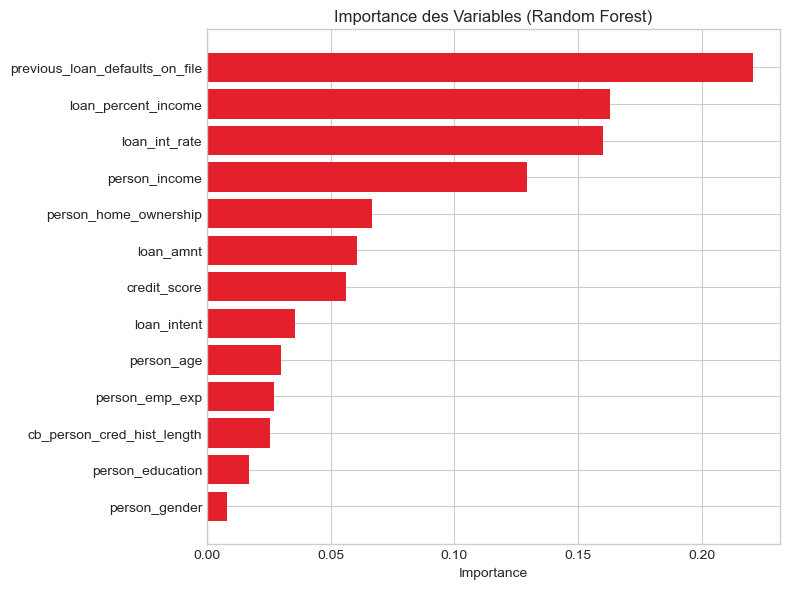

In [25]:
# Feature Importance du Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feature_importance['feature'], feature_importance['importance'], color='#E3202B')
ax.set_xlabel('Importance')
ax.set_title('Importance des Variables (Random Forest)')
plt.tight_layout()
plt.show()

---

## 6. Déploiement du Modèle

Une fois le meilleur modèle sélectionné, il faut le sauvegarder pour pouvoir l'utiliser en production.

### 6.1 Sauvegarder le modèle

Deux formats courants pour sauvegarder des modèles Python :

| Format | Extension | Description |
|--------|-----------|-------------|
| **Joblib** | `.joblib` | Optimisé pour les objets NumPy/Scikit-learn. Plus rapide pour les gros modèles. **Recommandé** |
| **Pickle** | `.pkl` | Format standard Python. Fonctionne pour tout objet Python. |

In [28]:
import joblib

# Sauvegarder le meilleur modèle (XGBoost) avec Joblib
joblib.dump(xgb_model, 'loan_approval_model.joblib')
print("✅ Modèle sauvegardé : loan_approval_model.joblib")

# Sauvegarder aussi le scaler (nécessaire pour la régression logistique)
joblib.dump(scaler, 'scaler.joblib')
print("✅ Scaler sauvegardé : scaler.joblib")

# Sauvegarder les encodeurs
joblib.dump(label_encoders, 'label_encoders.joblib')
print("✅ Encodeurs sauvegardés : label_encoders.joblib")

✅ Modèle sauvegardé : loan_approval_model.joblib
✅ Scaler sauvegardé : scaler.joblib
✅ Encodeurs sauvegardés : label_encoders.joblib


In [29]:
# Alternative avec Pickle (pour référence)
import pickle

with open('loan_approval_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ Modèle sauvegardé aussi en pickle : loan_approval_model.pkl")

✅ Modèle sauvegardé aussi en pickle : loan_approval_model.pkl


### 6.2 Charger et utiliser le modèle

In [30]:
# Charger le modèle sauvegardé
loaded_model = joblib.load('loan_approval_model.joblib')

# Faire une prédiction sur de nouvelles données
new_data = X_test.iloc[[0]]  # Exemple avec la première ligne du test set
prediction = loaded_model.predict(new_data)
proba = loaded_model.predict_proba(new_data)

print(f"Prédiction : {'Approuvé ✅' if prediction[0] == 1 else 'Rejeté ❌'}")
print(f"Probabilité d'approbation : {proba[0][1]:.2%}")

Prédiction : Rejeté ❌
Probabilité d'approbation : 0.27%


### 6.3 Créer une API avec FastAPI

Pour exposer le modèle dans une application, on peut créer une **API REST** avec FastAPI.

Voici un exemple de code à sauvegarder dans un fichier `api.py` :

```python
# api.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

# Charger le modèle et les encodeurs
model = joblib.load('loan_approval_model.joblib')
label_encoders = joblib.load('label_encoders.joblib')

app = FastAPI(title="Loan Approval API")

class LoanRequest(BaseModel):
    person_age: float
    person_gender: str
    person_education: str
    person_income: float
    person_emp_exp: int
    person_home_ownership: str
    loan_amnt: float
    loan_intent: str
    loan_int_rate: float
    loan_percent_income: float
    cb_person_cred_hist_length: float
    credit_score: int
    previous_loan_defaults_on_file: str

@app.post("/predict")
def predict(request: LoanRequest):
    # Convertir en DataFrame
    data = pd.DataFrame([request.dict()])
    
    # Encoder les variables catégorielles
    for col, le in label_encoders.items():
        if col in data.columns:
            data[col] = le.transform(data[col])
    
    # Prédiction
    prediction = model.predict(data)[0]
    probability = model.predict_proba(data)[0][1]
    
    return {
        "approved": bool(prediction),
        "probability": round(probability, 4),
        "message": "Prêt approuvé ✅" if prediction else "Prêt rejeté ❌"
    }

@app.get("/")
def root():
    return {"message": "Loan Approval API - POST /predict pour faire une prédiction"}
```

**Pour lancer l'API :**
```bash
pip install fastapi uvicorn
uvicorn api:app --reload
```

L'API sera accessible sur `http://localhost:8000` et la documentation interactive sur `http://localhost:8000/docs`.

---

## 7. Conclusion

### Résumé

| Étape | Action |
|-------|--------|
| 1. Exploration | Comprendre les données, identifier le déséquilibre |
| 2. Préparation | Encoder les catégories, split train/test |
| 3. Modélisation | Comparer 3 algorithmes (LogReg, RF, XGBoost) |
| 4. Évaluation | Choisir la métrique selon le contexte métier |
| 5. Déploiement | Sauvegarder le modèle, créer une API |

### Points clés

- **XGBoost** offre généralement les meilleures performances sur données tabulaires
- Le choix de la **métrique** dépend du coût métier des erreurs (FP vs FN)
- Toujours **sauvegarder les transformations** (scaler, encodeurs) avec le modèle
- **Joblib** est recommandé pour sauvegarder les modèles scikit-learn

### Pour aller plus loin

- Feature Engineering avancé (création de nouvelles variables)
- Hyperparameter Tuning (GridSearchCV, RandomSearchCV)
- Cross-validation pour une évaluation plus robuste
- Techniques de déséquilibre (SMOTE, class_weight)
- Explicabilité (SHAP, LIME)